In [3]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%cd APE_paper/docs/figures_notebooks
!git checkout YvonneJohansson

'rm' is not recognized as an internal or external command,
operable program or batch file.


C:\Users\Yvonne\Documents\Hernando_APE_paper\APE_paper\docs\figures_notebooks\APE_paper\docs\figures_notebooks


Cloning into 'APE_paper'...
C:\Users\Yvonne\.conda\envs\HMV_environment\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


branch 'YvonneJohansson' set up to track 'origin/YvonneJohansson'.


Switched to a new branch 'YvonneJohansson'


In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import urllib.request
from os.path import exists
import matplotlib.pylab as plt
import numpy as np
import pickle
from scipy.signal import decimate

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
import os
sys.path.insert(1, os.path.dirname(os.path.dirname(os.path.abspath(os.curdir))))
from scripts import YJ_analysis_utils as yj_utils
from scripts import yj_plotting as yj_plot

In [8]:
# # Extended Data 5S & 5T:

# Get dataset information:
dataset_name = 'DataOverview_ED5PQR.csv' # CORRECT TO NEW FIGURE NUMBER
zenodo = "https://zenodo.org/records/xxxxxxxxxxx/files/"
url = zenodo + dataset_name
dataset_path = '../../data/' + dataset_name

if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('DataOverview already in directory')

#print(dataset_path)
info = pd.read_csv(dataset_path)

DataOverview already in directory


In [9]:
info

,Unnamed: 0,AnimalID,Date,fiber_side,protocol1
0,1,TS24,20230929,right,SOR
1,2,TS26,20230918,right,SOR
2,3,TS27,20231003,right,SOR
3,4,TS32,20231026,right,SOR
4,5,TS33,20231102,right,SOR
5,6,TS34,20231031,right,SOR


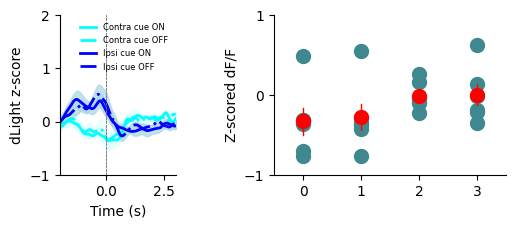

In [10]:
all_group_data = {'SOR_return_cueON_contra': [], 'SOR_return_cueOFF_contra': [], 'SOR_return_cueON_ipsi': [], 'SOR_return_cueOFF_ipsi': []}

APE_choice_peak_values = []
return_contra_cue_on_values = []
return_contra_cue_off_values = []
return_ipsi_cue_on_values = []
return_ipsi_cue_off_values = []

for i, mouse in enumerate(info['AnimalID']):
    date = str(info['Date'][i])
    fiber_side = info['fiber_side'][i]
    protocol = info['protocol1'][i]
    dataset_names = []
    nr_return_trials_cue_on = 0
    nr_return_trials_cue_off = 0
    CoT_trial_dataname = mouse + '_' + date + '_restructured_data.pkl'
    CoT_photo_dataname = mouse + '_' + date + '_smoothed_signal.npy' 
    dataset_names.extend([CoT_photo_dataname,CoT_trial_dataname])
    url = zenodo + dataset_name
    for j, dataset_name in enumerate(dataset_names): 
        dataset_path = '../../data/' + dataset_name
        if not exists(dataset_path):
            print('Downloading ' + dataset_name)
            urllib.request.urlretrieve(url, dataset_path)
        #else:
        #   print(dataset_name + ' already in directory')
        
        if j == 0:
            photometry_data = np.load(dataset_path)  
        if j == 1:  
            trial_data = pd.read_pickle(dataset_path)
            session_traces = yj_utils.SessionData(mouse, date, fiber_side, protocol, trial_data, photometry_data)

    alignements = ['choice','SOR_return_cueON_contra','SOR_return_cueOFF_contra', 'SOR_return_cueON_ipsi', 'SOR_return_cueOFF_ipsi']
    for a, alignement in enumerate(alignements):
        if alignement == 'choice':
            curr_data = session_traces.choice.contra_data
        elif alignement == 'SOR_return_cueON_contra':
            curr_data = session_traces.SOR_return_cueON.contra_data
        elif alignement == 'SOR_return_cueOFF_contra':
            curr_data = session_traces.SOR_return_cueOFF.contra_data
        elif alignement == 'SOR_return_cueON_ipsi':
            curr_data = session_traces.SOR_return_cueON.ipsi_data
        elif alignement == 'SOR_return_cueOFF_ipsi':
            curr_data = session_traces.SOR_return_cueOFF.ipsi_data

        curr_data_mean = decimate(curr_data.mean_trace, 10) # data aligned to start of return movement

        if alignement != 'choice':
            # all return data is aligned to the start of return movement (=side port out)
            # to align it to the return cue instead, which happens 20ms after side port out, it needs to be shifted: 
            t1 = np.pad(curr_data_mean, (0, 20))  # pad with 20 zeros (20ms with 10Hz sampling = 200, however decimate 10 above, hence only 20 datapoints)
            t2 = t1[20:]
            curr_data_mean = t2
            all_group_data[alignement].append(curr_data_mean)

        curr_data_time = decimate(curr_data.time_points, 10)
        curr_data_traces = decimate(curr_data.sorted_traces, 10)
        

        if alignement == 'choice':
            # extract how long it takes on average to the peak movement signal in a classic contra trial (center --> side port)
            start_inx = 8000
            APE_choice_time_range = curr_data_time[start_inx:start_inx + 8000]
            APE_choice_peak_index = np.argmax(curr_data_mean[start_inx:start_inx + 8000])
            
        # extract movement after the same time interval in the return trials: 
        amplitude = curr_data_mean[start_inx + APE_choice_peak_index]
            
        
        if alignement == 'SOR_return_cueON_contra':
            nr_return_trials_cue_on = nr_return_trials_cue_on + curr_data_traces.shape[0]
            return_contra_cue_on_values.append(amplitude)
        elif alignement == 'SOR_return_cueOFF_contra':
            nr_return_trials_cue_off = nr_return_trials_cue_off + curr_data_traces.shape[0]
            return_contra_cue_off_values.append(amplitude)
        elif alignement == 'SOR_return_cueON_ipsi':    
            nr_return_trials_cue_on = nr_return_trials_cue_on + curr_data_traces.shape[0]
            return_ipsi_cue_on_values.append(amplitude)
        elif alignement == 'SOR_return_cueOFF_ipsi':
            nr_return_trials_cue_off = nr_return_trials_cue_off + curr_data_traces.shape[0]
            return_ipsi_cue_off_values.append(amplitude)
        
    #print(f"Return trials: {nr_return_trials_cue_on:.0f} cue on, {nr_return_trials_cue_off:.0f} cue off, total cue on % : {(nr_return_trials_cue_on*100 / (nr_return_trials_cue_on + nr_return_trials_cue_off)):.2f}")
        

figure = yj_plot.plot_ED5ST(all_group_data, curr_data_time, return_contra_cue_on_values, return_contra_cue_off_values, return_ipsi_cue_on_values, return_ipsi_cue_off_values,'EarlyTraining')

# uncomment here to save the plot
dataset_path = '../../data/'
plt.savefig(dataset_path + 'ED5ST_EarlyTraining.png',
            transparent=True, bbox_inches='tight')         

In [80]:
# # Extended Data 5S & 5T:

# Get dataset information:
dataset_name = 'DataOverview_ED5ST_FirstCueSession.csv' # CORRECT TO NEW FIGURE NUMBER
zenodo = "https://zenodo.org/records/xxxxxxxxxxx/files/"
url = zenodo + dataset_name
dataset_path = '../../data/' + dataset_name

if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('DataOverview already in directory')

#print(dataset_path)
info = pd.read_csv(dataset_path)

DataOverview already in directory


In [81]:
info

,Unnamed: 0,AnimalID,Date,fiber_side,protocol1
0,4,TS32,20231026,right,SOR
1,5,TS33,20231026,right,SOR
2,6,TS34,20231026,right,SOR


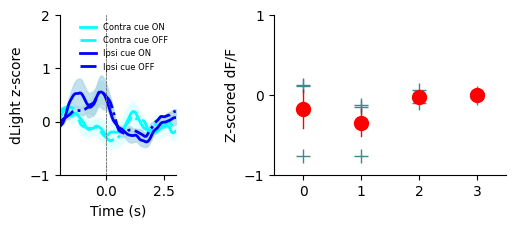

In [82]:
all_group_data = {'SOR_return_cueON_contra': [], 'SOR_return_cueOFF_contra': [], 'SOR_return_cueON_ipsi': [], 'SOR_return_cueOFF_ipsi': []}

APE_choice_peak_values = []
return_contra_cue_on_values = []
return_contra_cue_off_values = []
return_ipsi_cue_on_values = []
return_ipsi_cue_off_values = []

for i, mouse in enumerate(info['AnimalID']):
    date = str(info['Date'][i])
    fiber_side = info['fiber_side'][i]
    protocol = info['protocol1'][i]
    dataset_names = []
    nr_return_trials_cue_on = 0
    nr_return_trials_cue_off = 0
    CoT_trial_dataname = mouse + '_' + date + '_restructured_data.pkl'
    CoT_photo_dataname = mouse + '_' + date + '_smoothed_signal.npy' 
    dataset_names.extend([CoT_photo_dataname,CoT_trial_dataname])
    url = zenodo + dataset_name
    for j, dataset_name in enumerate(dataset_names): 
        dataset_path = '../../data/' + dataset_name
        if not exists(dataset_path):
            print('Downloading ' + dataset_name)
            urllib.request.urlretrieve(url, dataset_path)
        #else:
        #   print(dataset_name + ' already in directory')
        
        if j == 0:
            photometry_data = np.load(dataset_path)  
        if j == 1:  
            trial_data = pd.read_pickle(dataset_path)
            session_traces = yj_utils.SessionData(mouse, date, fiber_side, protocol, trial_data, photometry_data)

    alignements = ['choice','SOR_return_cueON_contra','SOR_return_cueOFF_contra', 'SOR_return_cueON_ipsi', 'SOR_return_cueOFF_ipsi']
    for a, alignement in enumerate(alignements):
        if alignement == 'choice':
            curr_data = session_traces.choice.contra_data
        elif alignement == 'SOR_return_cueON_contra':
            curr_data = session_traces.SOR_return_cueON.contra_data
        elif alignement == 'SOR_return_cueOFF_contra':
            curr_data = session_traces.SOR_return_cueOFF.contra_data
        elif alignement == 'SOR_return_cueON_ipsi':
            curr_data = session_traces.SOR_return_cueON.ipsi_data
        elif alignement == 'SOR_return_cueOFF_ipsi':
            curr_data = session_traces.SOR_return_cueOFF.ipsi_data

        curr_data_mean = decimate(curr_data.mean_trace, 10) # data aligned to start of return movement

        if alignement != 'choice':
            # all return data is aligned to the start of return movement (=side port out)
            # to align it to the return cue instead, which happens 20ms after side port out, it needs to be shifted: 
            t1 = np.pad(curr_data_mean, (0, 20))  # pad with 20 zeros (20ms with 10Hz sampling = 200, however decimate 10 above, hence only 20 datapoints)
            t2 = t1[20:]
            curr_data_mean = t2
            all_group_data[alignement].append(curr_data_mean)

        curr_data_time = decimate(curr_data.time_points, 10)
        curr_data_traces = decimate(curr_data.sorted_traces, 10)
        

        if alignement == 'choice':
            # extract how long it takes on average to the peak movement signal in a classic contra trial (center --> side port)
            start_inx = 8000
            APE_choice_time_range = curr_data_time[start_inx:start_inx + 8000]
            APE_choice_peak_index = np.argmax(curr_data_mean[start_inx:start_inx + 8000])
        # extract movement after the same time interval in the return trials: 
        amplitude = curr_data_mean[start_inx + APE_choice_peak_index]
        
        if alignement == 'SOR_return_cueON_contra':
            nr_return_trials_cue_on = nr_return_trials_cue_on + curr_data_traces.shape[0]
            return_contra_cue_on_values.append(amplitude)
        elif alignement == 'SOR_return_cueOFF_contra':
            nr_return_trials_cue_off = nr_return_trials_cue_off + curr_data_traces.shape[0]
            return_contra_cue_off_values.append(amplitude)
        elif alignement == 'SOR_return_cueON_ipsi':    
            nr_return_trials_cue_on = nr_return_trials_cue_on + curr_data_traces.shape[0]
            return_ipsi_cue_on_values.append(amplitude)
        elif alignement == 'SOR_return_cueOFF_ipsi':
            nr_return_trials_cue_off = nr_return_trials_cue_off + curr_data_traces.shape[0]
            return_ipsi_cue_off_values.append(amplitude)
        
    #print(f"Return trials: {nr_return_trials_cue_on:.0f} cue on, {nr_return_trials_cue_off:.0f} cue off, total cue on % : {(nr_return_trials_cue_on*100 / (nr_return_trials_cue_on + nr_return_trials_cue_off)):.2f}")
        

figure = yj_plot.plot_ED5ST(all_group_data, curr_data_time, return_contra_cue_on_values, return_contra_cue_off_values, return_ipsi_cue_on_values, return_ipsi_cue_off_values, 'FirstCueSession')

# uncomment here to save the plot
dataset_path = '../../data/'
plt.savefig(dataset_path + 'ED5ST_1stCueSession.png',
            transparent=True, bbox_inches='tight')